# Photomosaic generation
### IN the following, we will in the simplest of manners recreat a picture using crops of a large image dataset. 




In [88]:
import skimage as sk

In [89]:
import numpy as np 
from skimage.io import imread, imsave
from skimage.color import rgb2hsv, rgb2lab
from skimage.transform import rescale, resize
import matplotlib.pyplot as plt
import os
import fnmatch
from tqdm import tqdm
from sklearn.metrics import pairwise_distances_argmin, pairwise_distances
import random
import cv2

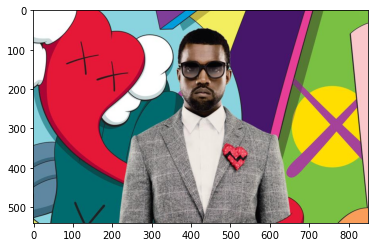

In [90]:
im = imread("kanye_west.jpg")
plt.imshow(im)

### We rescale the image, this makes the pixels "larger".
#### The scaling and crop size are the parameters you want to play with to control the "resolution of your final image"

In [91]:
rescale_ratio = 1/10
rescaled = rescale(im, rescale_ratio, multichannel=True)
rescaled_h, rescaled_w = rescaled.shape[:-1]

label_row_size = 150
label_col_size = 150

n_rows = rescaled_h * label_row_size
n_columns =rescaled_w * label_col_size

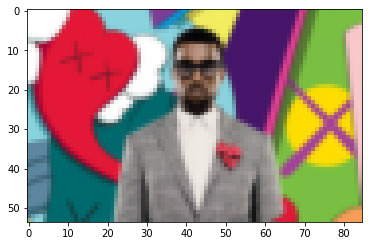

In [92]:
plt.imshow(rescaled)

In [97]:
rescaled.shape

(54, 85, 3)

### We need to know what is the mean color of each image in our image bank.  This will be the perceived color. Since each of our images may play the role of a pixel we need to make all images the same size.
### A fast and simple way to make your images all same size is to crop their center. Resizing is also possible but takes way more time.

In [93]:
def crop_center(im, new_width, new_height):
    height, width = im.shape[:-1]   # Get dimensions
    
    
    left = int((width - new_width)/2)
    top = int((height - new_height)/2)
    right = int((width + new_width)/2)
    bottom = int((height + new_height)/2)

    # Crop the center of the image
    im2 = im[top:bottom,left:right,:]
    return im2

In [ ]:
#Image bank directory
# chr(92) = "\"
imgs_dir = r"""C:\Users\TheMatrix\Desktop\AESTHETIC2\KanyeWestCovers"""

In [94]:
def extract_mean(imgs_dir , crop_row,crop_column):
    im_paths = []
    means = []
    for file in tqdm(os.listdir(imgs_dir)):
        if fnmatch.fnmatch(file, "*.jpg") or fnmatch.fnmatch(file, "*.jpeg") or fnmatch.fnmatch(file, "*.png") :
            try:
                im_ = sk.img_as_ubyte(crop_center(imread(imgs_dir + chr(92) + file), crop_row, crop_column))/255 
                if len(im_.shape) < 3 or im_.shape[0]<crop_row or  im_.shape[1]<crop_column :
                    print("weird image")#small image or black and white
                    print(imgs_dir + chr(92) + file)
                else:
                    im_paths.append(imgs_dir + chr(92) + file)
                    mean = np.mean(rgb2lab(im_[:,:,:3]) , axis = (0,1))
                    means.append(mean)
            except Exception as e:
                print(e)
                print(file)
                continue
    means = np.array(means)
    return means,im_paths

means, im_paths = extract_mean(imgs_dir,label_row_size, label_col_size)

 48%|██████████████████████████████████████▌                                          | 90/189 [00:03<00:01, 55.33it/s]

weird image
C:\Users\TheMatrix\Desktop\AESTHETIC2\KanyeWestCovers\image (1).jpeg
weird image
C:\Users\TheMatrix\Desktop\AESTHETIC2\KanyeWestCovers\image (2).jpeg


 56%|████████████████████████████████████████████▍                                   | 105/189 [00:03<00:01, 77.56it/s]

weird image
C:\Users\TheMatrix\Desktop\AESTHETIC2\KanyeWestCovers\image (3).jpeg
weird image
C:\Users\TheMatrix\Desktop\AESTHETIC2\KanyeWestCovers\image (4).jpeg
weird image
C:\Users\TheMatrix\Desktop\AESTHETIC2\KanyeWestCovers\image (5).jpeg
weird image
C:\Users\TheMatrix\Desktop\AESTHETIC2\KanyeWestCovers\image (6).jpeg
weird image
C:\Users\TheMatrix\Desktop\AESTHETIC2\KanyeWestCovers\image (7).jpeg
weird image
C:\Users\TheMatrix\Desktop\AESTHETIC2\KanyeWestCovers\image (8).jpeg
weird image
C:\Users\TheMatrix\Desktop\AESTHETIC2\KanyeWestCovers\image (9).jpeg
weird image
C:\Users\TheMatrix\Desktop\AESTHETIC2\KanyeWestCovers\image.jpeg


 64%|███████████████████████████████████████████████████▏                            | 121/189 [00:03<00:01, 51.68it/s]

not enough values to unpack (expected 2, got 1)
kanye-west--jay-z--watch-the-throne-album-cover-by-riccardo-.jpg


 84%|███████████████████████████████████████████████████████████████████▎            | 159/189 [00:04<00:00, 40.80it/s]

Could not find a format to read the specified file in single-image mode
Kanye.jpg


100%|████████████████████████████████████████████████████████████████████████████████| 189/189 [00:05<00:00, 33.03it/s]


In [95]:
len(im_paths)

174

In [96]:
means.shape

(174, 3)

### if we want to assign each image to a pixel in the original image, we need to compute a distance between colors. A good space to compute such a distance for perceptual purposes is cielab.  Notice that we have used the same color space to extract mean colors in our image bank previously.

In [99]:
rescaled = rgb2lab(rescaled)

In [100]:
rescaled.shape

(54, 85, 3)

In [101]:
pixels = np.reshape(rescaled,(rescaled_h*rescaled_w,3))

In [102]:
pixels.shape

(4590, 3)

### Each pixel of the rescaled (target) image is assigned the image of which the mean is the closest. Some images are just the best fit to some surfaces (that will have homogenous colors in general). This means that these images will be the only one to appear in our reconstruction. In order to force the use of multiple images, we randomly choose an image between the 10 closest means to a target pixel color.

In [103]:
distances = pairwise_distances(pixels, means)
labels = []
for i in range(len(pixels)):
    d_ = distances[i,:]
    indices = np.argsort(d_)[:10]
    labels.append(random.choice(indices))

In [104]:
labels = np.reshape(labels, (rescaled_h,rescaled_w))
labels.shape

(54, 85)

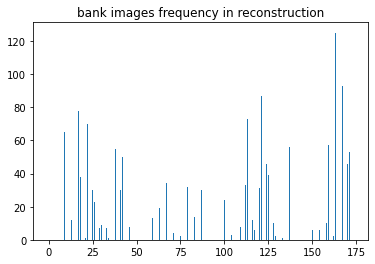

In [114]:
plt.hist(labels.flatten(), bins = 1000)
plt.title("bank images frequency in reconstruction")
plt.show()

### Now that we know which picture to assign to each pixel, let's reconstruct the image.

In [106]:
new_image = np.zeros((n_rows,n_columns,3), dtype = 'uint8')
for i in tqdm(range(rescaled_h)):
    for j in range(rescaled_w):
        label = labels[i,j]
        pth = im_paths[label]
        label_img = sk.img_as_ubyte(crop_center(imread(pth),label_col_size, label_row_size))[:,:,:3]
        try:
            new_image[i * label_row_size: (i+1) * label_row_size ,j * label_col_size: (j+1) * label_col_size, : ] = label_img
        except Exception as e:
            print(e)
            print("path :", pth)
            print("label:", label)
            continue

100%|██████████████████████████████████████████████████████████████████████████████████| 54/54 [01:27<00:00,  1.61s/it]


### These images can be very large, saving them is safer than showing them with pyplot. I have also reduced the size so that they can be uploadable.

In [115]:
save_im = cv2.resize(cv2.cvtColor(new_image, cv2.COLOR_RGB2BGR) , (im.shape[1]*3, im.shape[0]*3))
cv2.imwrite("kanye_try3.jpeg", save_im)

True